#Demonstration of parallel monte carlo simulation with pysd

This notebook demonstrates the use of ipython's [parallelization capability](http://ipython.org/ipython-doc/2/parallel/parallel_intro.html) to speed up Monte Carlo Analysis of a system dynamics model, using [pysd](https://github.com/JamesPHoughton/pysd).

In [1]:
%matplotlib inline
import pysd
import numpy as np
import matplotlib.pyplot as plt

The model we'll use for this demonstration represents a bank account that is recieving a constant stream of deposits, and accumulates compound interest. Not a very interesting model, but there you go.

![What is up with this image resolution?](Bank_Balance.png)

In [2]:
model = pysd.read_vensim('bank_balance.mdl')
model.get_free_parameters()

{'balance_init': '100', 'deposits': '5', 'interest_rate': '0.001'}

We'll sample a uniform random value that represents the interest rate. We take 10000 samples for this Monte Carlo Analysis.

In [3]:
interest_rate = np.random.uniform(high=.1, size=10000)
print interest_rate

[ 0.04859189  0.08973965  0.04714421 ...,  0.07324901  0.09589162
  0.00348889]


#Standard Monte Carlo

We'll try and see what the distribution of bank balances is at the end of the simulation, given our distribution of input values.

1 loops, best of 3: 10.6 s per loop


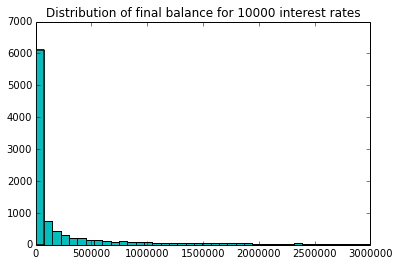

In [4]:
%%timeit

final_balances = []
for rate in interest_rate:
    stocks = model.run(params={'interest_rate':rate})
    final_balances.append(stocks['balance'].iloc[-1])
    
plt.hist(final_balances, bins=40)
plt.title('Distribution of final balance for %i interest rates'%len(final_balances));

We can alternatly use python list comprehensions in place of the for loop:

1 loops, best of 3: 11 s per loop


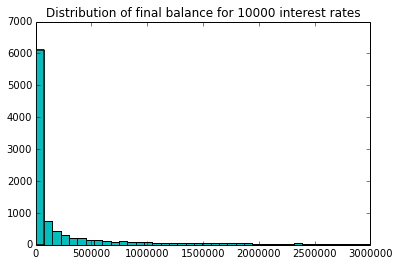

In [5]:
%%timeit

final_balances = [model.run(params={'interest_rate':rate})['balance'].iloc[-1] for rate in interest_rate]

plt.hist(final_balances, bins=40)
plt.title('Distribution of final balance for %i interest rates'%len(final_balances));

#Parallel Monte Carlo
Now we'll try using ipython's parallelization capability to take full advantage of the machine's computing power. Here I'm distributing the set of runs across the four cores on my computer, but ipython lets you set up clusters spanning multiple cores on multiple computers fairly easily.

Before running this code, remember to start a cluster on your local machine using ipython notebook's dashboard.

This section of code connects to that cluster, and gives us the hooks for accessing it.

In [6]:
from IPython.parallel import Client
cli = Client()
dview = cli[:]
print "Using %i cores"%len(cli.ids)

Using 4 cores


Before we run the simulations, we push a copy of the model to each ipython engine. We then map the randomly generated interest rates between the cores, run the model once for each value, and compile the resulting final balances.

1 loops, best of 3: 2.9 s per loop


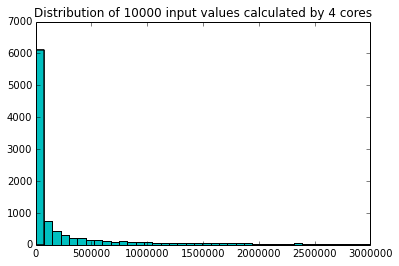

In [7]:
%%timeit

dview.push({'model':model})
result = dview.map(lambda x: model.run(params={'interest_rate':x})['balance'].iloc[-1], interest_rate)

plt.hist(result.result, bins=40)
plt.title('Distribution of %i input values calculated by %i cores'%(len(interest_rate), len(cli.ids)));

Authored by James Houghton:  [james.p.houghton@gmail.com](mailto:james.p.houghton@gmail.com)

Using pysd v0.1.1, December 16, 2014